In [32]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Downloading the model

CLIP models are distributed as TorchScript modules.

In [33]:
import sys
sys.path.append("../../../rugpt/")

In [34]:
from clip.evaluate.utils import (
    get_text_batch, get_image_batch, get_tokenizer,
    show_test_images, show_similarity,
    prepare_classes, call_model,
    show_topk_probs,
    load_weights_only,
    get_topk_accuracy,
    show_topk_accuracy
)
from clip.evaluate.tvd import get_text_probs_from_dataset
import torch
import json


In [78]:
model, args = load_weights_only(
    "/home/jovyan/dalle/models/small/model_vit_v3/",
    visual_encoder_dim=512,
    iteration=140000,
    visual_encoder_name="ViT-B/32"
)

In [79]:
model = model.cuda().float().eval()

In [80]:
import numpy as np
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")

Model parameters: 216,492,801


## Show similarity

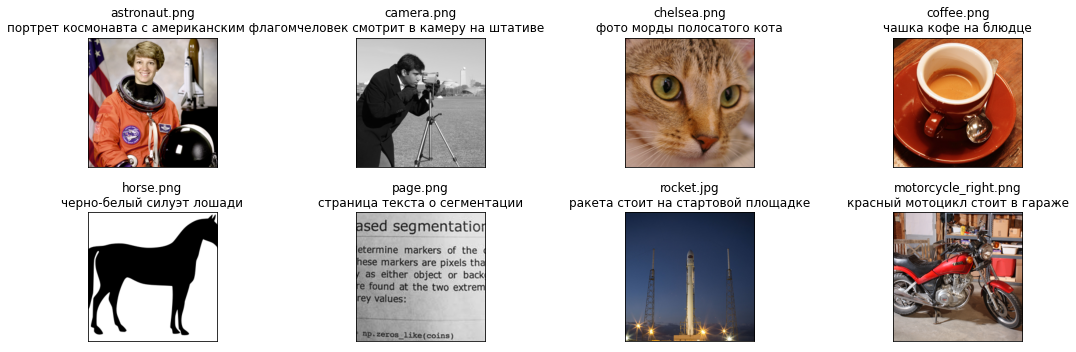

In [81]:
images, texts = show_test_images(args)

In [82]:
tokenizer = get_tokenizer()

### Building features

In [83]:
input_ids, attention_mask = get_text_batch(["Это " + desc for desc in texts], tokenizer, args)
img_input = get_image_batch(images, args.img_transform, args)

In [84]:
with torch.no_grad():
    logits_per_image, logits_per_text = model(
        img_input={"x": img_input},
        text_input={"x": input_ids, "attention_mask": attention_mask}
    )

### Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [85]:
similarity = logits_per_text.cpu().numpy() / 100

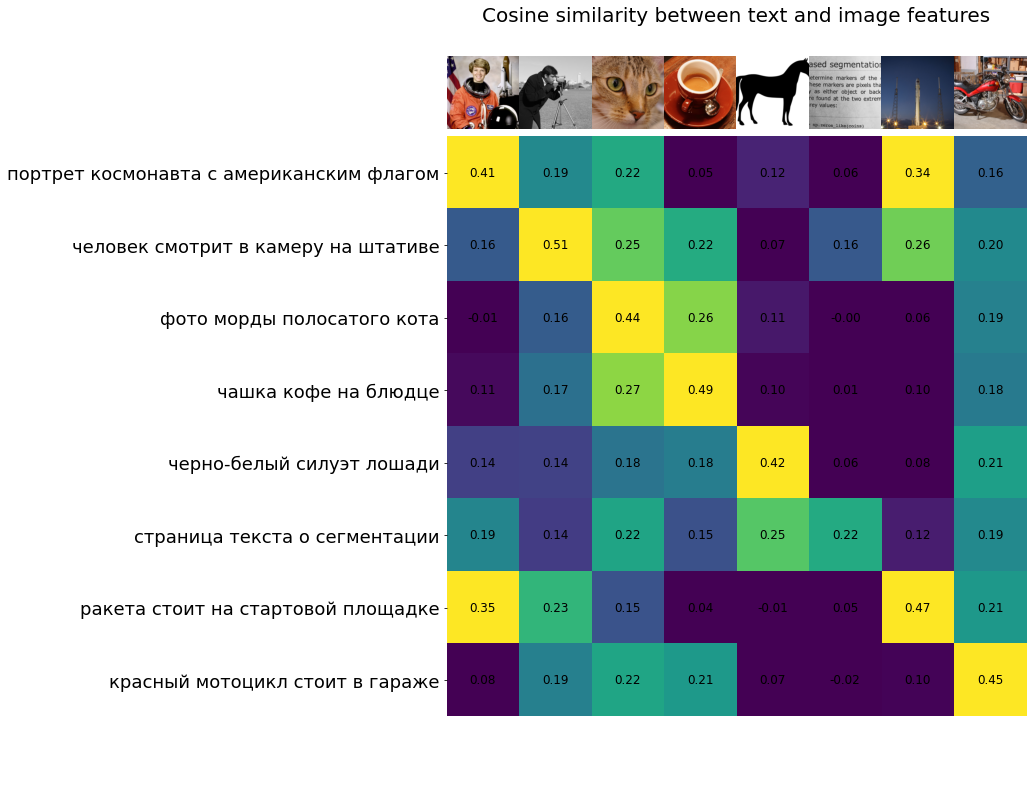

In [86]:
_ = show_similarity(images, texts, similarity, args)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [87]:
with open("../../clip/evaluate/classes.json", "r") as file:
    classes = json.load(file)

In [88]:
logits_per_image, logits_per_text = call_model(model, tokenizer, args, prepare_classes(classes), images)

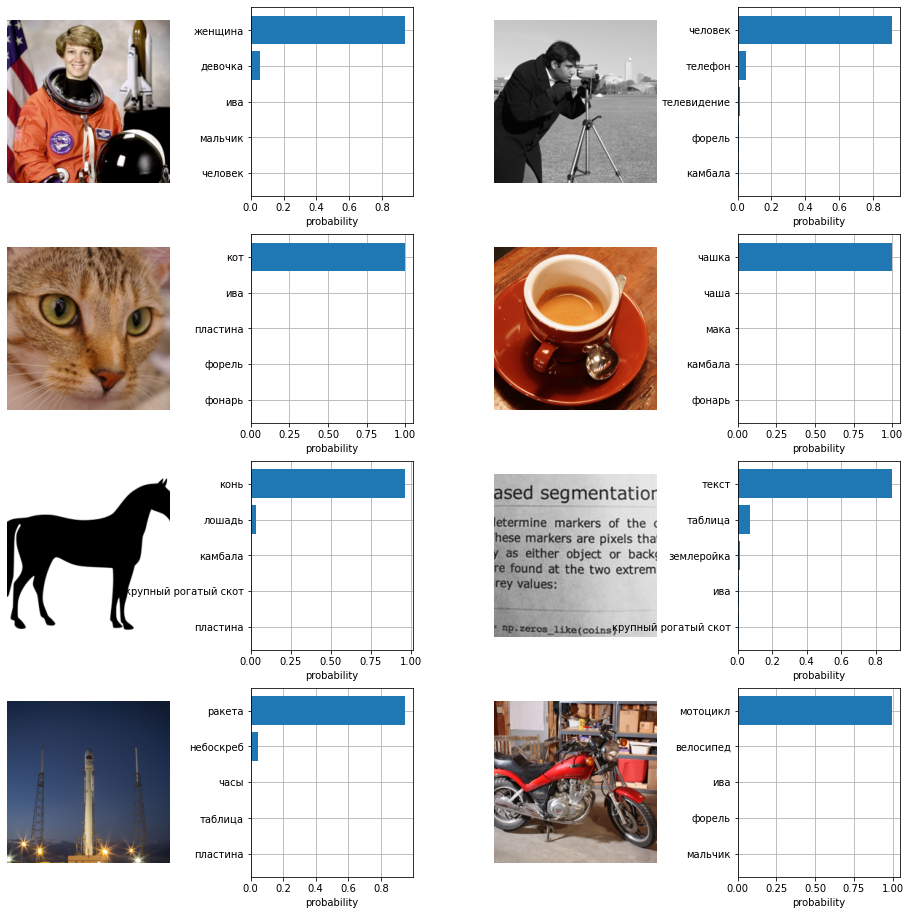

In [89]:
show_topk_probs(images, classes, logits_per_image, args, k=5)

## Evaluate CIFAR100

In [90]:
probs, labels = get_text_probs_from_dataset(model, args, tokenizer, name="CIFAR100")

Files already downloaded and verified


100%|██████████| 10000/10000 [44:06<00:00,  3.78it/s]


In [91]:
with open("../../clip/evaluate/cifar100/cifar100classes.json", "r") as file:
    cifar100classes = json.load(file)

In [92]:
probs = np.array(probs)

#### Top-5 accuracy

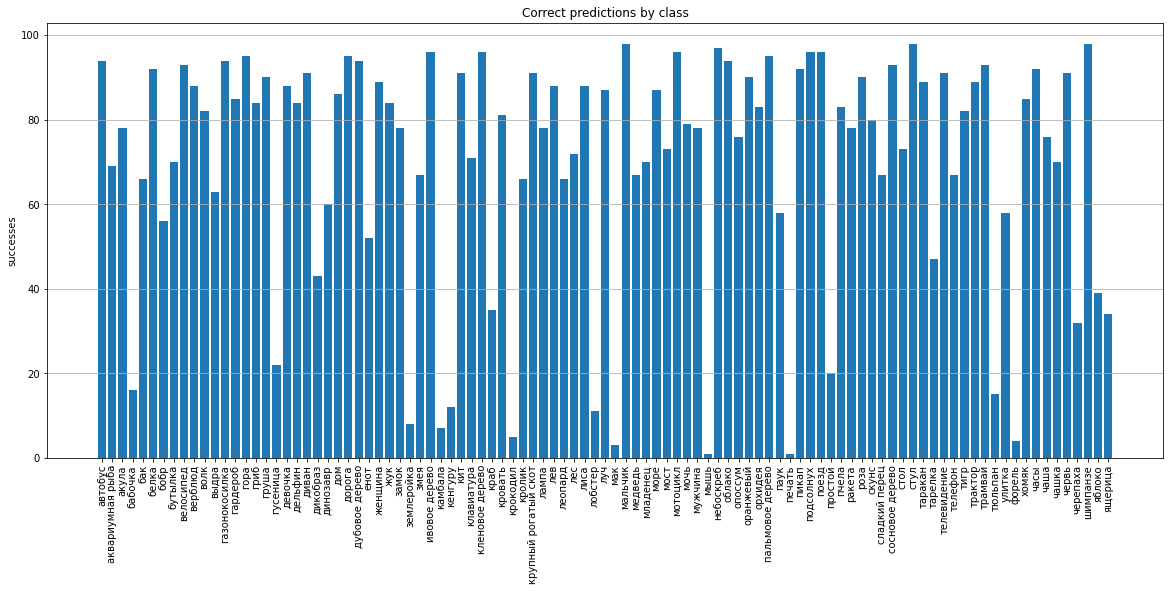

In [93]:
_ = show_topk_accuracy(labels, probs, cifar100classes, k=5)

In [94]:
get_topk_accuracy(labels, probs, 5)

0.6961

#### Top-1 accuracy

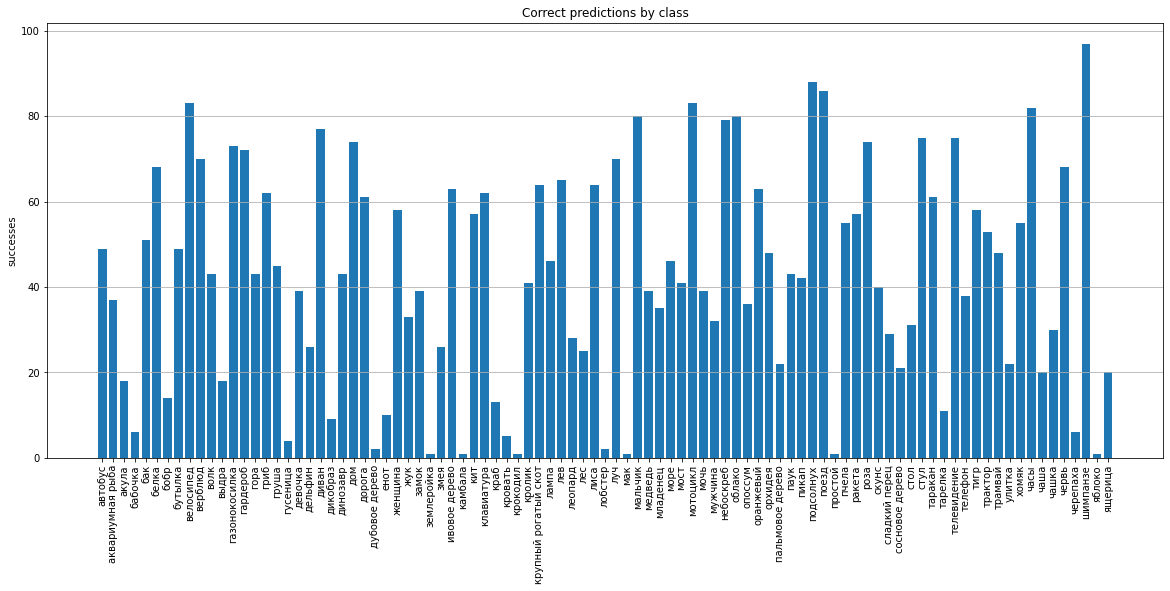

In [95]:
_ = show_topk_accuracy(labels, probs, cifar100classes, k=1)

In [96]:
get_topk_accuracy(labels, probs, 1)

0.4021

## Evaluate CIFAR10

In [97]:
probs10, labels10 = get_text_probs_from_dataset(model, args, tokenizer, name="CIFAR10")

Files already downloaded and verified


100%|██████████| 10000/10000 [19:51<00:00,  8.39it/s]


In [98]:
with open("../../clip/evaluate/cifar10/cifar10classes.json", "r") as file:
    cifar10classes = json.load(file)

In [99]:
probs10 = np.array(probs10)

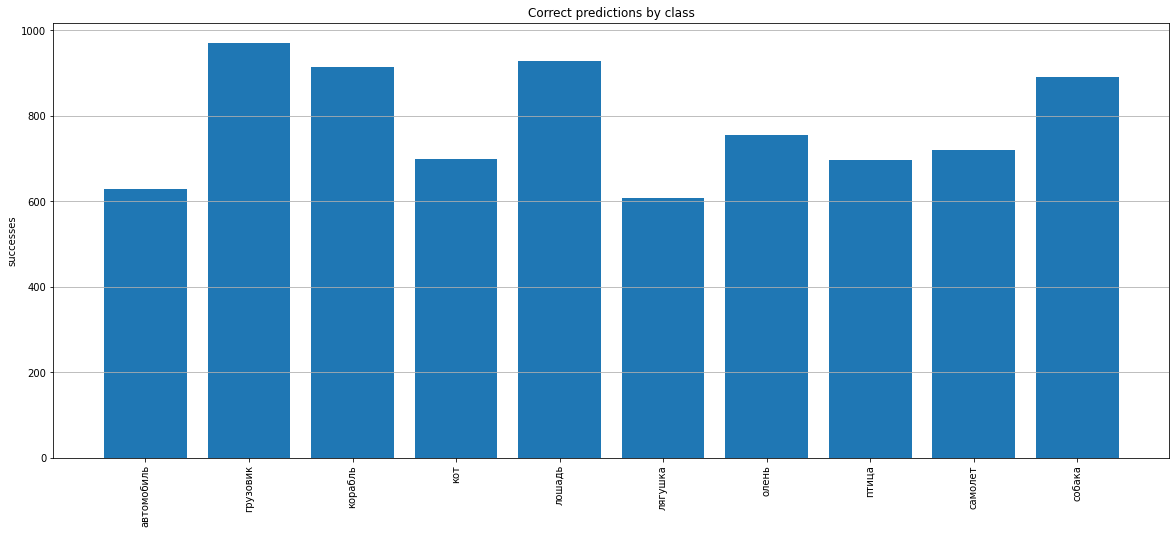

In [108]:
_ = show_topk_accuracy(labels10, probs10, cifar10classes, k=1)

In [104]:
get_topk_accuracy(labels10, probs10, 5)

0.9834

In [105]:
get_topk_accuracy(labels10, probs10, 1)

0.7803